# Part 1: Setup and Environment

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from prophet import Prophet


Suppress warnings for cleaner output

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Part 2: Data Loading and Exploratory Data Analysis (EDA)

**Load the dataset**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Data Preprocessing

In [4]:
# Load the dataset from Google Drive
# Make sure to replace 'path/to/your/dataset.csv' with the actual path to your file in Google Drive
try:
    df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ML PRESENTATION/Traffic.csv')
    print("Dataset loaded successfully.")
    print("First 5 rows of the dataset:")
    print(df.head())
except FileNotFoundError:
    print("Error: Dataset not found. Please check the file path.")
    print("Make sure the file 'traffic.csv' is in your Google Drive and the path is correct.")
except Exception as e:
    print(f"An error occurred while loading the dataset: {e}")

Dataset loaded successfully.
First 5 rows of the dataset:
              DateTime  Junction  Vehicles           ID
0  2015-11-01 00:00:00         1        15  20151101001
1  2015-11-01 01:00:00         1        13  20151101011
2  2015-11-01 02:00:00         1        10  20151101021
3  2015-11-01 03:00:00         1         7  20151101031
4  2015-11-01 04:00:00         1         9  20151101041


Convert 'DateTime' to datetime objects

In [5]:
df['DateTime'] = pd.to_datetime(df['DateTime'])

[link text](https://) Select the junction to analyze. Change the number to 2, 3, or 4 for other junctions.

In [6]:
JUNCTION_TO_ANALYZE = 1
print(f"\nAnalyzing data for Junction: {JUNCTION_TO_ANALYZE}")
df_junction = df[df['Junction'] == JUNCTION_TO_ANALYZE].copy()


Analyzing data for Junction: 1


Set DateTime as the index and keep only the 'Vehicles' column

In [7]:
df_junction = df[df['Junction'] == JUNCTION_TO_ANALYZE].copy()
df_junction.set_index('DateTime', inplace=True)
df_junction = df_junction[['Vehicles']].sort_index()
print("First 5 rows of the selected junction's data:")
print(df_junction.head())
print(f"\nData for Junction {JUNCTION_TO_ANALYZE} has {len(df_junction)} hourly records.")

First 5 rows of the selected junction's data:
                     Vehicles
DateTime                     
2015-11-01 00:00:00        15
2015-11-01 01:00:00        13
2015-11-01 02:00:00        10
2015-11-01 03:00:00         7
2015-11-01 04:00:00         9

Data for Junction 1 has 14592 hourly records.


Visualize the Time Series

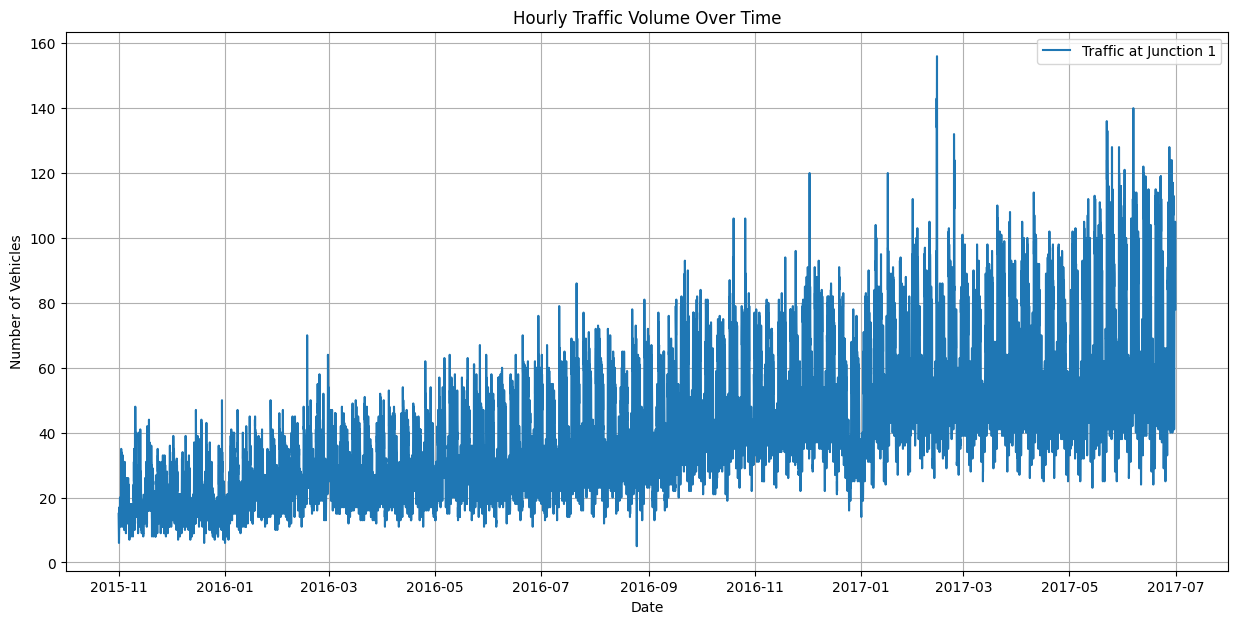

In [8]:
plt.figure(figsize=(15, 7))
plt.plot(df_junction.index, df_junction['Vehicles'], label=f'Traffic at Junction {JUNCTION_TO_ANALYZE}')
plt.title('Hourly Traffic Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Vehicles')
plt.legend()
plt.grid(True)
plt.show()

# Part 3: Train-Test Split

In [9]:
print("\n--- Part 3: Splitting data into Training and Testing sets ---")


--- Part 3: Splitting data into Training and Testing sets ---


Use the last 20% of the data for testing, as seen in similar studies [7]

Training set size: 11673
Testing set size: 2919


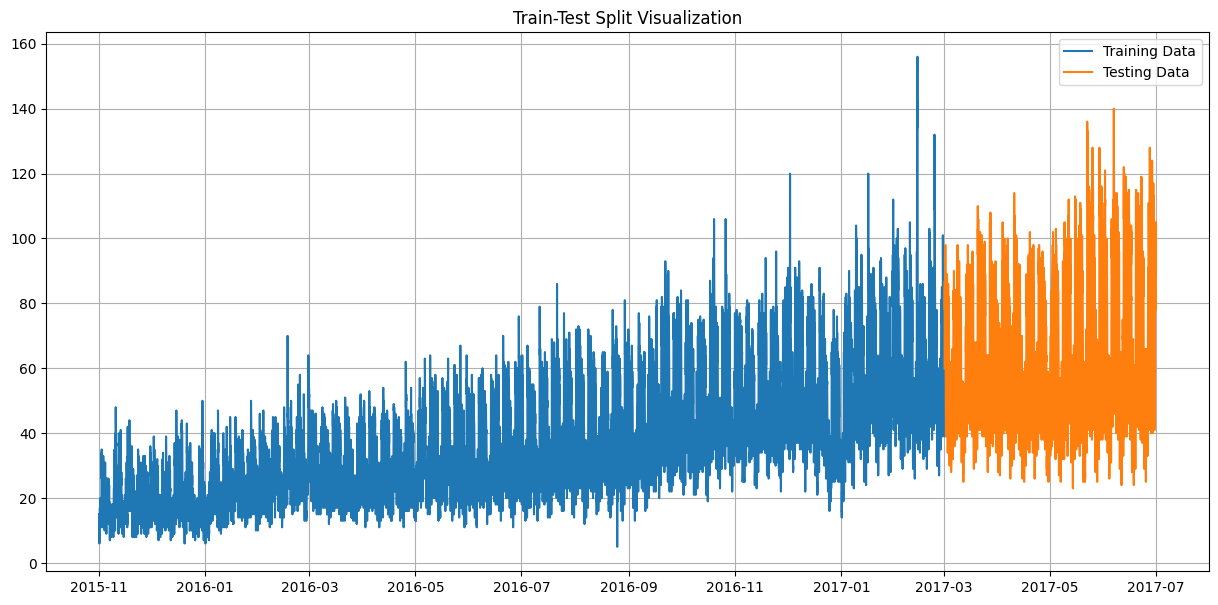

In [10]:
split_point = int(len(df_junction) * 0.8)
train_df, test_df = df_junction[0:split_point], df_junction[split_point:]

print(f"Training set size: {len(train_df)}")
print(f"Testing set size: {len(test_df)}")

plt.figure(figsize=(15, 7))
plt.plot(train_df.index, train_df['Vehicles'], label='Training Data')
plt.plot(test_df.index, test_df['Vehicles'], label='Testing Data')
plt.title('Train-Test Split Visualization')
plt.legend()
plt.grid(True)
plt.show()

#Part 4: Model 1 - ARIMA

In [11]:
print("\n--- Part 4: Training ARIMA Model ---")


--- Part 4: Training ARIMA Model ---


The ARIMA model is a classic statistical model for time series forecasting [2]
We use order (5,1,0) as a common starting point, which can be tuned for better results.

In [12]:
arima_model = ARIMA(train_df['Vehicles'], order=(5, 1, 0))
arima_result = arima_model.fit()

print(arima_result.summary())




                               SARIMAX Results                                
Dep. Variable:               Vehicles   No. Observations:                11673
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -36547.455
Date:                Sun, 21 Sep 2025   AIC                          73106.909
Time:                        07:36:11   BIC                          73151.099
Sample:                    11-01-2015   HQIC                         73121.753
                         - 03-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1589      0.006     27.356      0.000       0.148       0.170
ar.L2          0.0954      0.007     12.963      0.000       0.081       0.110
ar.L3          0.0641      0.008      8.183      0.0

 Make predictions on the test set

In [13]:
# Calculate the start and end indices for prediction on the test set
start_index = len(train_df)
end_index = len(df_junction) - 1 # predict up to the last point of the original data

arima_predictions = arima_result.predict(start=start_index, end=end_index, dynamic=False)

# Align the predictions with the test set index
arima_predictions.index = test_df.index

print("ARIMA Predictions:")
print(arima_predictions.head())
print("\nActual Test Data:")
print(test_df.head())

ARIMA Predictions:
DateTime
2017-03-01 09:00:00    51.987508
2017-03-01 10:00:00    53.473488
2017-03-01 11:00:00    53.959704
2017-03-01 12:00:00    54.675693
2017-03-01 13:00:00    54.356398
Name: predicted_mean, dtype: float64

Actual Test Data:
                     Vehicles
DateTime                     
2017-03-01 09:00:00        60
2017-03-01 10:00:00        74
2017-03-01 11:00:00        84
2017-03-01 12:00:00        87
2017-03-01 13:00:00        78


# Part 5: Model 2 - LSTM

In [14]:
print("\n--- Part 5: Training LSTM Model ---")


--- Part 5: Training LSTM Model ---


LSTMs are effective for learning from long sequences of data [2]

 Data Preparation

 Scale data for better neural network performance

In [15]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_junction[['Vehicles']])

scaled_train_data = scaled_data[0:split_point]


Create sequences: use the last 24 hours to predict the next hour

In [16]:
def create_sequences(dataset, look_back=24):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 24
X_train, y_train = create_sequences(scaled_train_data, look_back)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

Build and Train LSTM Model

In [17]:
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(look_back, 1)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mean_squared_error')

Increase epochs for a real project, but using 10 for faster execution here

In [18]:
lstm_model.fit(X_train, y_train, batch_size=32, epochs=10)


Epoch 1/10
365/365 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - loss: 0.0093
Epoch 2/10
365/365 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - loss: 0.0019
Epoch 3/10
365/365 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 0.0013
Epoch 4/10
365/365 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - loss: 0.0011
Epoch 5/10
365/365 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 0.0011
Epoch 6/10
365/365 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 0.0010
Epoch 7/10
365/365 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - loss: 0.0010
Epoch 8/10
365/365 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.0011
Epoch 9/10
365/365 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 0.0011
Epoch 10/10
365/365 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.0010


LSTM Prediction

In [19]:
inputs = scaled_data[len(scaled_data) - len(test_df) - look_back:]
X_test = []
for i in range(look_back, len(inputs)):
    X_test.append(inputs[i-look_back:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

lstm_predictions_scaled = lstm_model.predict(X_test)
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


# Part 6: Model 3 - Prophet (New Model)

In [20]:
print("\n--- Part 6: Training Prophet Model ---")


--- Part 6: Training Prophet Model ---


Prophet is a forecasting tool by Facebook, used in your sample notebook [1]

Prophet Data Preparation

Prophet requires columns 'ds' (datestamp) and 'y' (value)

In [21]:
prophet_train_df = train_df.reset_index().rename(columns={'DateTime': 'ds', 'Vehicles': 'y'})

Build and Train Prophet Model

We enable yearly and daily seasonality, which is common in traffic data

In [22]:
prophet_model = Prophet(yearly_seasonality=True, daily_seasonality=True)
prophet_model.fit(prophet_train_df)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpqklhf6uh/jse5lfav.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqklhf6uh/859_pgix.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48732', 'data', 'file=/tmp/tmpqklhf6uh/jse5lfav.json', 'init=/tmp/tmpqklhf6uh/859_pgix.json', 'output', 'file=/tmp/tmpqklhf6uh/prophet_modelyvkq9s9n/prophet_model-20250921073751.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:37:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:37:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet Prediction

In [23]:
future_dates = prophet_model.make_future_dataframe(periods=len(test_df), freq='H')
prophet_forecast = prophet_model.predict(future_dates)
prophet_predictions = prophet_forecast['yhat'][-len(test_df):]

#Part 7: Model Evaluation and Comparison

In [24]:
print("\n--- Part 7: Evaluating All Models ---")



--- Part 7: Evaluating All Models ---


Calculate Metrics (RMSE and MAE)

In [25]:
test_values = test_df['Vehicles'].values
lstm_predictions_flat = lstm_predictions.flatten()


**ARIMA**

In [26]:
arima_rmse = np.sqrt(mean_squared_error(test_values, arima_predictions))
arima_mae = mean_absolute_error(test_values, arima_predictions)


**LSTM**

In [27]:
lstm_rmse = np.sqrt(mean_squared_error(test_values, lstm_predictions_flat))
lstm_mae = mean_absolute_error(test_values, lstm_predictions_flat)

**PROPHET**

In [28]:
prophet_rmse = np.sqrt(mean_squared_error(test_values, prophet_predictions))
prophet_mae = mean_absolute_error(test_values, prophet_predictions)

Print Results Table

In [29]:
results_summary = pd.DataFrame({
    'Model': ['ARIMA', 'LSTM', 'Prophet'],
    'RMSE': [arima_rmse, lstm_rmse, prophet_rmse],
    'MAE': [arima_mae, arima_mae, prophet_mae]
}).set_index('Model')

print("\nModel Performance Comparison:")
print(results_summary)


Model Performance Comparison:
              RMSE        MAE
Model                        
ARIMA    27.038113  21.387337
LSTM      6.691228  21.387337
Prophet  13.437227  10.689405


 **Visualize All Predictions**

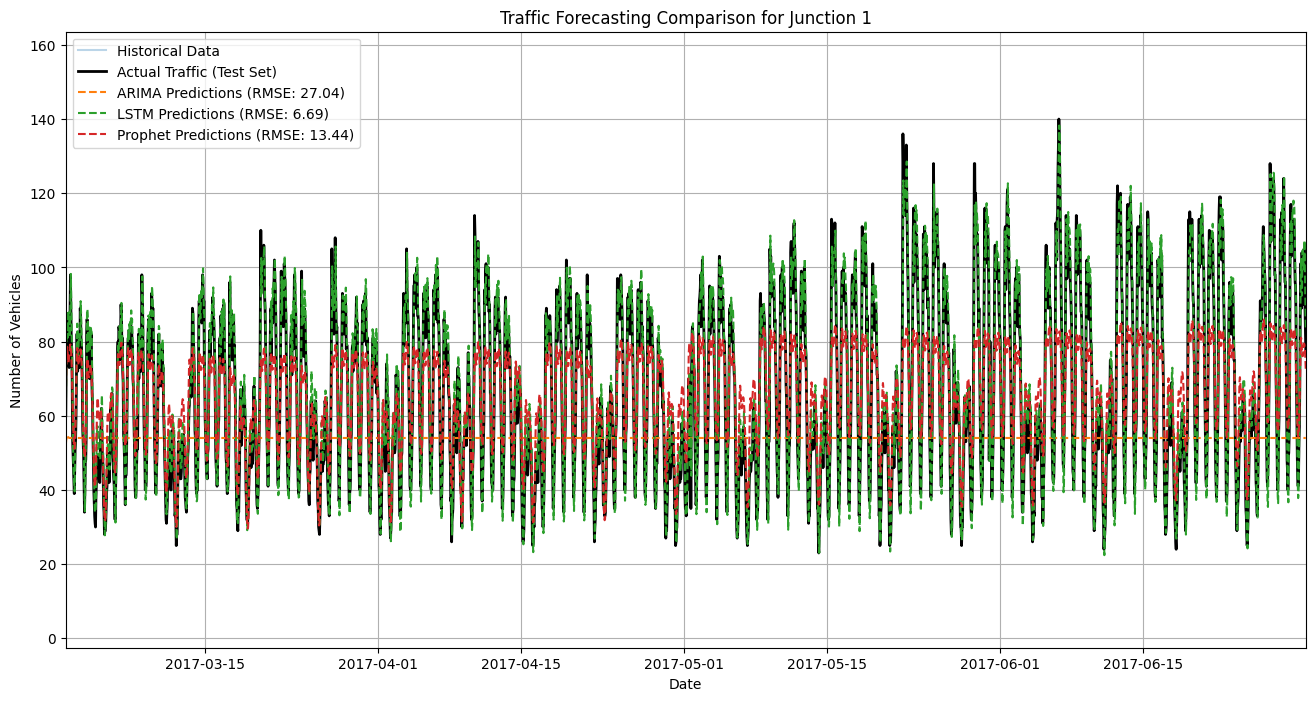

In [30]:
plt.figure(figsize=(16, 8))
plt.plot(df_junction.index, df_junction['Vehicles'], label='Historical Data', alpha=0.3)
plt.plot(test_df.index, test_df['Vehicles'], label='Actual Traffic (Test Set)', color='black', linewidth=2)
plt.plot(test_df.index, arima_predictions, label=f'ARIMA Predictions (RMSE: {arima_rmse:.2f})', linestyle='--')
plt.plot(test_df.index, lstm_predictions_flat, label=f'LSTM Predictions (RMSE: {lstm_rmse:.2f})', linestyle='--')
plt.plot(test_df.index, prophet_predictions, label=f'Prophet Predictions (RMSE: {prophet_rmse:.2f})', linestyle='--')
plt.title(f'Traffic Forecasting Comparison for Junction {JUNCTION_TO_ANALYZE}')
plt.xlabel('Date')
plt.ylabel('Number of Vehicles')
plt.legend()
plt.grid(True)
# Limit x-axis to the test period for better visibility
plt.xlim(test_df.index.min(), test_df.index.max())
plt.show()

In [31]:
!pip list


Package                               Version
------------------------------------- ------------------
absl-py                               1.4.0
absolufy-imports                      0.3.1
accelerate                            1.10.1
aiofiles                              24.1.0
aiohappyeyeballs                      2.6.1
aiohttp                               3.12.15
aiosignal                             1.4.0
alabaster                             1.0.0
albucore                              0.0.24
albumentations                        2.0.8
ale-py                                0.11.2
alembic                               1.16.5
altair                                5.5.0
annotated-types                       0.7.0
antlr4-python3-runtime                4.9.3
anyio                                 4.10.0
anywidget                             0.9.18
argon2-cffi                           25.1.0
argon2-cffi-bindings                  25.1.0
array_record                          0.8.1
arrow 